## Load Libraries

In [2]:
#coding:utf-8
import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 12, 4
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Customizng plots with style sheets
plt.style.use('ggplot')

## Read train data

In [65]:
basedir = "../data/"
action_train = pd.read_csv(basedir + "trainingset/action_train.csv")
orderFuture_train = pd.read_csv(basedir + "trainingset/orderFuture_train.csv")
orderHistory_train = pd.read_csv(basedir + "trainingset/orderHistory_train.csv")
userComment_train = pd.read_csv(basedir + "trainingset/userComment_train.csv")
userProfile_train = pd.read_csv(basedir + "trainingset/userProfile_train.csv")
# origin_train_data = pd.read_csv(basedir + "origin_train_data.csv")
print action_train.shape
print pd.to_datetime(action_train['actionTime'].min(), unit='s')
print pd.to_datetime(action_train['actionTime'].max(), unit='s')

(1334856, 3)
2016-08-13 20:10:58
2017-09-10 23:57:45


## Read Test Data

In [66]:
action_test = pd.read_csv(basedir + "test/action_test.csv")
orderFuture_test = pd.read_csv(basedir + "test/orderFuture_test.csv")
orderHistory_test = pd.read_csv(basedir + "test/orderHistory_test.csv")
userComment_test = pd.read_csv(basedir + "test/userComment_test.csv")
userProfile_test = pd.read_csv(basedir + "test/userProfile_test.csv")
print action_test.shape
print pd.to_datetime(action_test['actionTime'].min(), unit='s')
print pd.to_datetime(action_test['actionTime'].max(), unit='s')

(331204, 3)
2016-09-14 16:45:04
2017-09-10 23:50:38


## Check missing

In [67]:
print userProfile_train.shape
print userProfile_train.isnull().sum()
print userProfile_test.isnull().sum()
print orderFuture_train.shape
print userComment_train.isnull().sum()
# print userProfile_train.province.mode()

(40307, 4)
userid          0
gender      24547
province     3895
age         35565
dtype: int64
userid         0
gender      6067
province    1004
age         8857
dtype: int64
(40307, 2)
userid                 0
orderid                0
rating                 0
tags                3109
commentsKeyWords    5771
dtype: int64


In [ ]:
userProfile_train['province'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.xticks(rotation=40)
plt.ylabel("$users num$")
plt.title('$Province$')

In [ ]:
userProfile_train['gender'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$Gender$')

In [ ]:
userProfile_train['age'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$Age$')

In [ ]:
action_train['actionType'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$actionType$')

Text(0.5,1,u'$orderType$')

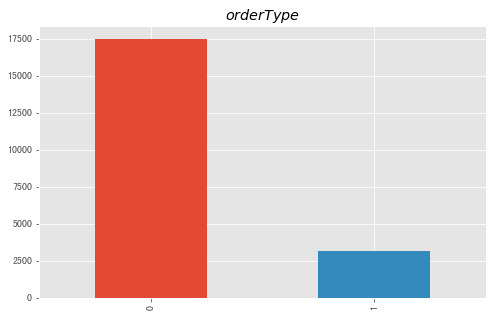

In [5]:
orderHistory_train['orderType'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$orderType$')

In [ ]:
orderHistory_train['country'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.title('$country$')

In [ ]:
orderHistory_train['continent'].value_counts().plot(kind='bar', figsize=(16, 5))
plt.title('$continent$')

In [ ]:
userComment_train['rating'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('$rating$')

In [ ]:
orderHistory_train.groupby(['userid']).size().value_counts().plot(kind='bar', figsize=(16, 7))
# orderHistory_train.groupby(['userid']).size().plot(kind='bar', figsize=(10, 7))

根据上图的结果，绝大用户历史订单数量在1个或2个，结合后面的特征重要度，可见统计每个用户每个月的订单数量是不合理的。

## Look at categories of all object variables:

In [ ]:
var = ['gender', 'province', 'age']
for v in var:
    print '\nFrequency count for variable %s'%v
    print userProfile_train[v].value_counts()
    print userProfile_test[v].value_counts()

In [ ]:
var = ['orderType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print orderFuture_train[v].value_counts()

var = ['actionType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print action_train[v].value_counts()

In [ ]:
var = ['rating']
for v in var:
    print '\nFrequency count for variable %s'%v
    print userComment_train[v].value_counts()

## 针对orderHistory数据文件生成特征
**绝大多数用户的订单只有一个或者两个，所以只使用订单间隔的平均值作为特征**

In [63]:
continent_gdp = pd.read_csv(basedir + "continent.csv")
def createFeatureFromOrderHistory(orderHistoryFile, saveFile):
    orderHistory = pd.read_csv(basedir + orderHistoryFile)
    orderHistory = pd.merge(orderHistory, continent_gdp, on=["continent",], how='left')
    orderHistory = orderHistory.sort_values(by='orderTime', ascending=True)
    orderHistory_group = orderHistory.groupby("userid")
    orderHistory_dict = dict(list(orderHistory_group))
    orderHistory_time = []
    for userid, userid_orderHistory in orderHistory_dict.iteritems():
        orderTimeList = np.unique(np.array(userid_orderHistory['orderTime']))
        orderTypeList = np.array(userid_orderHistory['orderType'])
        # 统计orderType(0, 1)的个数
        orderTypeZeroSum = np.sum(orderTypeList == 0)
        orderTypeOneSum = np.sum(orderTypeList == 1)
        oneTime = []
        oneTime.append(userid)
        oneTime.append(orderTypeZeroSum)
        oneTime.append(orderTypeOneSum)
        # 统计用户历史订单中大陆的gdp均值
        oneTime.append(np.array(userid_orderHistory['continent_gdp']).mean())
        orderTimeInterval = []
        if len(orderTimeList) == 1:
            orderTimeInterval = [0]
        else:
            timeInterval = np.diff(orderTimeList)
            orderTimeInterval = [timeInterval.mean()]
        oneTime = oneTime + orderTimeInterval
        timeInterval = np.diff(orderTimeList)
        if len(timeInterval) < 3:
            timeInterval = [0] * (3 - len(timeInterval)) + list(timeInterval)
            timeInterval = np.array(timeInterval)
        oneTime = oneTime + list(timeInterval[-1:])
        orderHistory_time.append(oneTime)
    #     print oneTime
    columns = ['userid', 'orderType0Sum', 'orderType1Sum', 'continent_gdp', 'orderTimeMean', 'orderTimeInter1']
    df = pd.DataFrame(np.array(orderHistory_time), columns=columns)
    df.to_csv(basedir + saveFile, index=False)
createFeatureFromOrderHistory("orderHistory_train.csv", "feature_orderHistory_train.csv")
createFeatureFromOrderHistory("orderHistory_test.csv", "feature_orderHistory_test.csv")

## 针对userComment数据生成特征

In [46]:
def createFeatureFromUserComment(dataset):
    userComment = pd.read_csv(basedir + "userComment_" + dataset + ".csv")
    
    userComment_dict = dict(list(userComment.groupby('userid')))
    userComment_feature = []
    for userid, userComment in orderHistory_dict.iteritems():
        orderTimeList = np.unique(np.array(userid_orderHistory['orderTime']))
        orderTypeList = np.array(userid_orderHistory['orderType'])
#     
    return orderDf


print createFeature("test").head(3)


         userid  order_num  rating_mean  continent_gdp_mean
0  100000000371        1.0          NaN              0.6460
1  100000001215        NaN          NaN                 NaN
2  100000001445        5.0          5.0              1.4602


In [7]:
# print action_train[action_train.userid == 100000000013]['userid'].count()
action_train_group = action_train.groupby('userid')
user_action_dict = dict(list(action_train_group))
action9_order_result = []
count = 0
for userid, userid_action in user_action_dict.iteritems():
    actionTypeList = np.array(userid_action['actionType'])
    type9 = np.count_nonzero(actionTypeList == 9)
    orderNum = orderHistory_train[orderHistory_train.userid == userid]['userid'].count()
    action9_order_result.append([userid, type9, orderNum])
    count = count + 1
#     if count == 10:
#         break
print count
columns = ['userid', 'actionType9', 'orderNum']
df = pd.DataFrame(np.array(action9_order_result), columns=columns)
df = pd.merge(df, orderFuture_train, on=['userid'], how='left')
df.to_csv(basedir + "type9_order.csv", index=False)

40307


In [47]:
city_data = pd.read_csv(basedir + "city_info.data", delimiter='\t', names = ['province', 'city_gdp', 'city_gdp1'])
city_data.drop('city_gdp1', axis=1, inplace=True)
city_rate = pd.read_csv(basedir + "city_rate.csv")
def createUserProfileFeature(dataset):
    userProfile = pd.read_csv(basedir + "userProfile_" + dataset + ".csv")
    #userProfile_deal = pd.merge(userProfile, city_data, on=['province'], how='left')
    userProfile_deal = pd.merge(userProfile, city_rate, on=['province'], how='left')
    # 利用province_rate的中位值填充缺失值
    userProfile_deal['province_rate'].fillna(userProfile_deal['province_rate'].median(), inplace=True)
    userProfile_deal.drop('province', axis=1, inplace=True)
    print userProfile_deal.dtypes
    # userProfile_deal.drop('city_gdp', axis=1, inplace=True)
    # userProfile_deal['age'].fillna("null", inplace=True)

    def convertAge(x):
        if x == 'null':
            return 0
        x = str(x)
        num = int(x.split('后')[0])
        if(num == 0):
             return 18
        else:
            return 2018 - 1900 - num

    #userProfile_deal['age'] = userProfile_deal['age'].apply(lambda x: convertAge(x))
    return userProfile_deal
print createUserProfileFeature("train").head(10)

userid             int64
gender            object
age               object
province_rate    float64
dtype: object
         userid gender  age  province_rate
0  100000000013      男  60后          0.110
1  100000000111    NaN  NaN          0.255
2  100000000127    NaN  NaN          0.255
3  100000000231      男  70后          0.241
4  100000000379      男  NaN          0.241
5  100000000393      女  NaN          0.241
6  100000000423    NaN  NaN          0.005
7  100000000459    NaN  NaN          0.241
8  100000000465    NaN  NaN          0.241
9  100000000471      女  NaN          0.110


In [48]:
def createActionTimeFeature(dataset):
    action_dataset = pd.read_csv(basedir + "action_" + dataset + ".csv")
    orderFuture = pd.read_csv(basedir + "orderFuture_" + dataset + ".csv")
    
    action_train_group = action_dataset.groupby('userid')
    actionDf = pd.DataFrame(orderFuture['userid'], columns = ['userid'])

    actionDf = actionDf.join(action_train_group['actionTime'].mean(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_mean'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].max(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_max'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].min(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_min'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].std(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_std'}, inplace=True)
    return actionDf

print createActionTimeFeature('train').head(3)

         userid  actionTime_mean  actionTime_max  actionTime_min  \
0  100000000013     1.487925e+09      1503238340      1474300753   
1  100000000111     1.490971e+09      1490971479      1490971433   
2  100000000127     1.492553e+09      1497815268      1490695669   

   actionTime_std  
0    8.187104e+06  
1    2.371357e+01  
2    2.994918e+06  


In [58]:
def createTotalFeatures(dataset):
    action_type_rate = pd.read_csv(basedir + "action_rate_" + dataset + ".csv")
    user_month_action = pd.read_csv(basedir + "user_month_" + dataset + ".csv")
    order_time = pd.read_csv(basedir + 'feature_orderHistory_' + dataset + ".csv")
    orderDf = createFeature(dataset)
    #actionDf = createActionTimeFeature(dataset)
    userProfile_deal = createUserProfileFeature(dataset)
    
    action_result = pd.merge(user_month_action, action_type_rate, on=["userid"], how='left')
    print action_result.shape
    train_data = pd.merge(orderDf, action_result, on=['userid'], how='left')
    
    train_data = pd.merge(train_data, order_time, on=['userid'], how='left')
    # train_data = pd.merge(train_data, actionDf, on=['userid'], how='left')
    train_data = pd.merge(userProfile_deal, train_data, on = ['userid'], how = 'left')
    if dataset == 'train':
        train_data = pd.merge(orderFuture_train, train_data, on=['userid'], how='left')
        train_data.rename(columns={'orderType': 'label'}, inplace=True)

    action_interval_train = pd.read_csv(basedir + "action_interval_"+ dataset + ".csv")
    train_data = pd.merge(train_data, action_interval_train, on=['userid'], how='left')
    
    tag_score = pd.read_csv(basedir + "user_tagScore_" + dataset + ".csv")
    train_data = pd.merge(train_data, tag_score, on=['userid'], how='left')

    # One-Hot Coding
    # data = pd.get_dummies(data, columns=var_to_encode)
#     train_data = pd.get_dummies(train_data, columns=['gender'], dummy_na=True)
    #train_data = pd.get_dummies(train_data, columns=['province'], dummy_na=True)
#     train_data = pd.get_dummies(train_data, columns=['age'], dummy_na=True)
    train_data.drop('age', axis=1, inplace=True)
    train_data.drop('gender', axis=1, inplace=True)
    
    return train_data

train_data =  createTotalFeatures('train')
test_data = createTotalFeatures('test')
print train_data.head(1).to_csv(basedir + "train_data.csv", index=False)
print train_data.columns 
print test_data.columns

userid             int64
gender            object
age               object
province_rate    float64
dtype: object
(40307, 20)
userid             int64
gender            object
age               object
province_rate    float64
dtype: object
(10076, 20)
None
Index([u'userid', u'label', u'province_rate', u'order_num', u'rating_mean',
       u'continent_gdp_mean', u'month1', u'month2', u'month3', u'month4',
       ...
       u'action5DistanceTime', u'action6DistanceTime', u'action7DistanceTime',
       u'action8DistanceTime', u'action9DistanceTime', u'type1IntervalMin',
       u'type1IntervalMax', u'type1IntervalMean', u'type1IntervalStd',
       u'tagScore'],
      dtype='object', length=102)
Index([u'userid', u'province_rate', u'order_num', u'rating_mean',
       u'continent_gdp_mean', u'month1', u'month2', u'month3', u'month4',
       u'month5',
       ...
       u'action5DistanceTime', u'action6DistanceTime', u'action7DistanceTime',
       u'action8DistanceTime', u'action9DistanceTime'

In [50]:
target='label'
IDcol = 'userid'
predictors = [x for x in train_data.columns if x not in [target, IDcol]]

In [51]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        #  指定训练数据集和标签
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        # 指定测试数据集
        xgtest = xgb.DMatrix(dtest[predictors].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain['label'], eval_metric='auc')
    
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtest['label'].values, dtest_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtest['label'], dtest_predprob)
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.to_csv(basedir + "feature_importance.csv", index=True)
    print feat_imp
    feat_imp.plot(kind='bar', title='Feature Importances', figsize=(16, 5))
#     plt.xticks(rotation=40)
    plt.ylabel('Feature Importance Score')

421

Model Report
Accuracy : 0.9313
AUC Score (Train): 0.953592
lastInteval2           348
actionType6Rate        324
action5min             322
lastInteval1           321
lastInteval4           304
lastInteval3           277
intevalMean            276
actionType5Rate        251
firstInteval           249
last3IntevalStd        241
action1min             236
actionType1Rate        225
type1IntervalMin       215
intevalStd             209
action6min             180
last3IntevalMean       172
intevalMin             171
action5mean            169
province_rate          169
last1Action            165
type1IntervalMean      155
action1mean            152
type1IntervalMax       151
month4                 147
action5DistanceTime    147
tagScore               145
action1DistanceTime    139
action1std             137
action5std             134
actionType7Rate        131
                      ... 
action7std              33
action8max              33
action2Distance         33
firstAction       

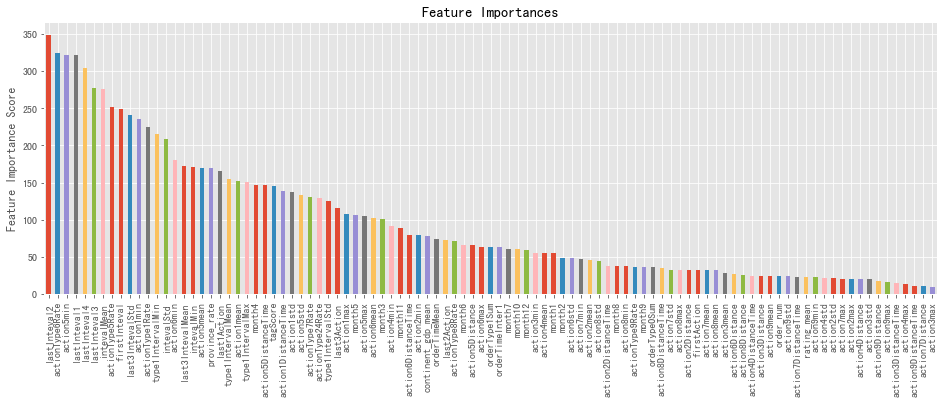

In [52]:
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5, # 树的最大深度
        min_child_weight=1, # 决定最小叶子节点样本权重和
        # 在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点，Gamma指定了节点分裂所需的最小损失函数下降值
        # 值越大，算法越保守
        gamma=0, 
        subsample=0.8, # 控制对于每颗树，随机采样的比例，0.8适合本题目
        colsample_bytree=0.8, # 控制每棵树随机采样的列数的占比
        objective= 'binary:logistic',
        # nthread=4, XGBoost运行时的线程数，缺省值是当前系统可以获得的最大线程数
        scale_pos_weight=1, # 在各类样本十分不平衡时，把这个参数设定为一个正值，可以使算法更快收敛
        seed=27 # 随机数的种子，设置它可以复现随机数据的结果，也可以用于调整参数
        )

train_data_sample = train_data.sample(frac=1.0)  # 全部打乱
cut_idx = int(round(0.2 * train_data.shape[0]))
train_test, train_train = train_data.iloc[:cut_idx], train_data.iloc[cut_idx:]
# print train_data.shape, train_test.shape, train_train.shape  # (40307, 126) (8061, 126) (32246, 126)

modelfit(xgb1, train_train, train_test, predictors, cv_folds=5)

In [14]:
# xgb1.fit(train_data[predictors], train_data[target], eval_metric='auc')
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
submit.to_csv(basedir + "submit_20180119.csv", index = False)

In [ ]:
xgb2 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

train_data_sample = train_data.sample(frac=1.0)  # 全部打乱
cut_idx = int(round(0.3 * train_data_sample.shape[0]))
train_test, train_train = train_data_sample.iloc[:cut_idx], train_data_sample.iloc[cut_idx:]
# print train_data.shape, train_test.shape, train_train.shape  # (40307, 126) (8061, 126) (32246, 126)

# modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)
xgb2.fit(train_train[predictors], train_train['label'], eval_metric='auc')

dtest_predictions = xgb2.predict(train_test[predictors])
dtest_predprob = xgb2.predict_proba(train_test[predictors])[:,1]
        
#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(train_test['label'].values, dtest_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(train_test['label'], dtest_predprob)

In [ ]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1.fit(train_data[predictors], train_data[target], eval_metric='auc')
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
print submit.to_csv(basedir + "submit_20180115.csv", index = False)

In [ ]:
# param_test1 = {
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,6,2)
# }
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
# iid: 独立同分布
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=259, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc', n_jobs=1, iid=False, cv=5, verbose=5)
gsearch1.fit(train_data[predictors], train_data[target])

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=337, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5, verbose=5)
gsearch1.fit(train_data[predictors],train_data[target])

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.4,
        n_estimators=505,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)

In [ ]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.4,
        n_estimators=375,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_data, train_data, predictors, cv_folds=5)

In [ ]:
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
print submit.to_csv(basedir + "submit_c.csv", index = False)